In [ ]:
import numpy as np   
import pandas as pd   
import os 
import string
import glob 
import tensorflow as tf 
from tensorflow.keras.utils import pad_sequences # type: ignore
from keras.models import Model  # type: ignore
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation  # type: ignore
from keras.layers import concatenate, BatchNormalization, Input # type: ignore
from tensorflow.keras.layers import add # type: ignore
from keras.utils import to_categorical, plot_model  # type: ignore
from keras.applications.inception_v3 import InceptionV3, preprocess_input  # type: ignore
import matplotlib.pyplot as plt  
import cv2 


In [5]:
def load_description(text): 
    mapping = dict() 
    for line in text.split("\n"): 
        token = line.split("\t") 
        if len(line) < 2:   # remove short descriptions 
            continue
        img_id = token[0].split('.')[0] # name of the image 
        img_des = token[1]              # description of the image 
        if img_id not in mapping: 
            mapping[img_id] = list() 
        mapping[img_id].append(img_des) 
    return mapping 
  
token_path = 'src/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read() 
descriptions = load_description(text) 
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
def clean_description(desc): 
	for key, des_list in desc.items(): 
		for i in range(len(des_list)): 
			caption = des_list[i] 
			caption = [ch for ch in caption if ch not in string.punctuation] 
			caption = ''.join(caption) 
			caption = caption.split(' ') 
			caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()] 
			caption = ' '.join(caption) 
			des_list[i] = caption 

clean_description(descriptions) 
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [7]:
def to_vocab(desc): 
    words = set() 
    for key in desc.keys(): 
        for line in desc[key]: 
            words.update(line.split()) 
    return words 
vocab = to_vocab(descriptions)

In [8]:
images = 'src/flickr_data/Flickr_Data/Images/'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg') 

train_path = 'src/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n") 
train_img = [] 
for im in img: 
	if(im[len(images):] in train_images): 
		train_img.append(im) 
		
# load descriptions of training set in a dictionary.
def load_clean_descriptions(des, dataset): 
	dataset_des = dict() 
	for key, des_list in des.items(): 
		if key+'.jpg' in dataset: 
			if key not in dataset_des: 
				dataset_des[key] = list() 
			for line in des_list: 
				desc = 'startseq ' + line + ' endseq'
				dataset_des[key].append(desc) 
	return dataset_des 

train_descriptions = load_clean_descriptions(descriptions, train_images) 
train_descriptions['1000268201_693b08cb0e']


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [9]:
test_path = 'src/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

x_test = open(test_path, 'r', encoding = 'utf-8').read().split("\n")

test_images = set(open(test_path, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img:
    if (i[len(images):] in test_images): 
        test_img.append(i) 

len(test_img)

1000

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore

def preprocess_img(img_path): 
	# inception v3 accepts img in 299 * 299 * 3 
	img = load_img(img_path, target_size = (299, 299)) 
	x = img_to_array(img) 
	# Add one more dimension 
	x = np.expand_dims(x, axis = 0) 
	x = preprocess_input(x) 
	return x 

def encode(image): 
	image = preprocess_img(image) 
	vec = model.predict(image) 
	vec = np.reshape(vec, (vec.shape[1])) 
	return vec 

if not os.path.exists('data/processed/train_encoded_features.npy'):
    base_model = InceptionV3(weights='imagenet') 
    model = Model(base_model.input, base_model.layers[-2].output) 
    # run the encode function on all train images and store the feature vectors in a dictionary
    encoding_train = {} 
    for img in train_img: 
        encoding_train[img[len(images):]] = encode(img)

    np.save('data/processed/train_encoded_features.npy', encoding_train)
else:
    # Load the encoded features from the file
    encoding_train = np.load('data/processed/train_encoded_features.npy', allow_pickle=True).item() 

In [11]:
if not os.path.exists('data/processed/test_encoded_features.npy'):
    base_model = InceptionV3(weights='imagenet') 
    model = Model(base_model.input, base_model.layers[-2].output) 

    encoding_test = {}
    for img in test_img:
        encoding_test[img[len(images):]] = encode(img)
    np.save('data/processed/test_encoded_features.npy', encoding_test)
else:
    # Load the encoded features from the file
    encoding_test = np.load('data/processed/test_encoded_features.npy', allow_pickle=True).item() 

In [12]:
# list of all training captions 
all_train_captions = [] 
for key, val in train_descriptions.items(): 
	for caption in val: 
		all_train_captions.append(caption) 

# consider only words which occur atleast 10 times 
vocabulary = vocab 
threshold = 10 
word_counts = {} 
for cap in all_train_captions: 
	for word in cap.split(' '): 
		word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold] 

# word mapping to integers 
ixtoword = {} 
wordtoix = {} 

ix = 1
for word in vocab: 
	wordtoix[word] = ix 
	ixtoword[ix] = word 
	ix += 1
	
# find the maximum length of a description in a dataset 
max_length = max(len(des.split()) for des in all_train_captions) 
max_length


34

In [13]:
train_features = encoding_train
vocab_size = len(ixtoword) + 1

X1, X2, y = list(), list(), list() 
for key, des_list in train_descriptions.items(): 
	pic = train_features[key + '.jpg'] 
	for cap in des_list: 
		seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix] 
		for i in range(1, len(seq)): 
			in_seq, out_seq = seq[:i], seq[i] 
			in_seq = pad_sequences([in_seq], maxlen = max_length)[0] 
			out_seq = to_categorical([out_seq], num_classes = vocab_size)[0] 
			# store 
			X1.append(pic) 
			X2.append(in_seq) 
			y.append(out_seq) 

# image feature, input sequence, and output sequence
X1 = np.array(X1)
X2 = np.array(X2) 
y = np.array(y) 

In [14]:
# load glove vectors for embedding layer 
embeddings_index = {} 
glove_path ='src/glove.6B.200d.txt'
glove = open(glove_path, 'r', encoding = 'utf-8').read() 
for line in glove.split("\n"): 
	values = line.split(" ") 
	word = values[0] 
	indices = np.asarray(values[1: ], dtype = 'float32') 
	embeddings_index[word] = indices 

emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))  
for word, i in wordtoix.items(): 
	emb_vec = embeddings_index.get(word) 
	if emb_vec is not None: 
		emb_matrix[i] = emb_vec 
emb_matrix.shape


(1652, 200)

In [15]:
# Input Layers
ip1 = Input(shape = (2048, )) # image features
ip2 = Input(shape = (max_length, )) # text sequences

# Image Feature Processing
fe1 = Dropout(0.2)(ip1) # reduce overfitting
fe2 = Dense(256, activation = 'relu')(fe1) # fully connected Dense layer

# Caption Sequence Processing
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2) 
se2 = Dropout(0.2)(se1) 
se3 = LSTM(256)(se2) 

decoder1 = add([fe2, se3]) 
decoder2 = Dense(256, activation = 'relu')(decoder1) 

outputs = Dense(vocab_size, activation = 'softmax')(decoder2) 

model = Model(inputs = [ip1, ip2], outputs = outputs)


In [16]:
if not os.path.exists('data/processed/trained_model.keras'):
    model.layers[2].set_weights([emb_matrix]) 
    model.layers[2].trainable = False

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam') 

    model.fit([X1, X2], y, epochs = 50, batch_size = 256) 

    model.save('data/processed/trained_model.keras')
else:
    model = tf.keras.models.load_model('data/processed/trained_model.keras')

In [17]:
model = tf.keras.models.load_model('data/processed/trained_model.keras')

In [18]:
def greedy_search(pic): 
	start = 'startseq'
	for i in range(max_length): 
		seq = [wordtoix[word] for word in start.split() if word in wordtoix] 
		seq = pad_sequences([seq], maxlen = max_length) 
		yhat = model.predict([pic, seq]) 
		yhat = np.argmax(yhat) 
		word = ixtoword[yhat] 
		start += ' ' + word 
		if word == 'endseq': 
			break
	final = start.split() 
	final = final[1:-1] 
	final = ' '.join(final) 
	return final


In [ ]:
import pickle

# Save the necessary files for the app
with open('vocab.pkl', 'wb') as f:
    pickle.dump(ixtoword, f)

with open('wordtoix.pkl', 'wb') as f:
    pickle.dump(wordtoix, f)

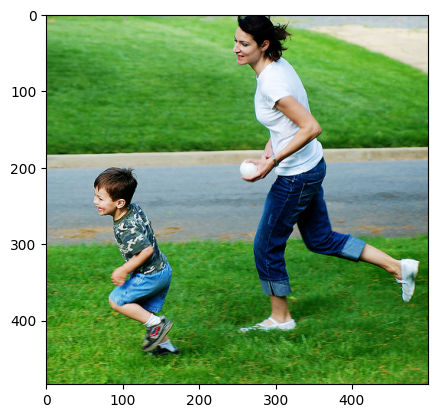

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
two young boys playing baseball


In [19]:
pic = list(encoding_test.keys())[255]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

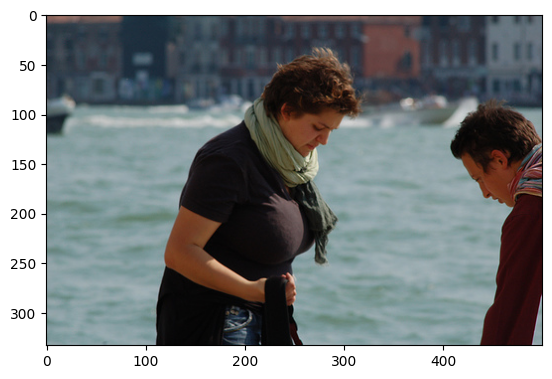

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
group of people are standing in the snow


In [18]:
pic = list(encoding_test.keys())[256]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

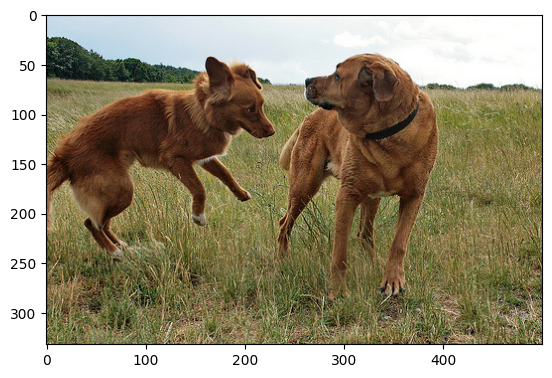

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
two dogs are playing together in the grass


In [37]:
pic = list(encoding_test.keys())[305]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

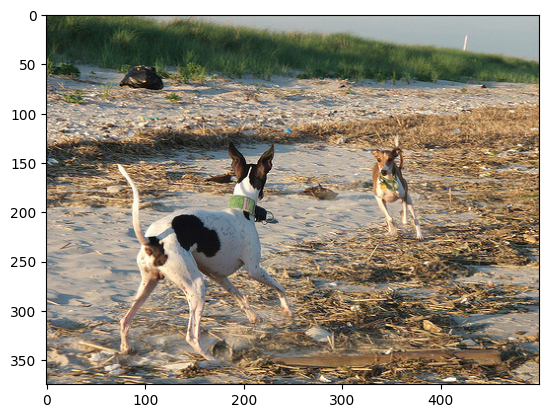

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
two dogs run through the dry grass


In [36]:
pic = list(encoding_test.keys())[303]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

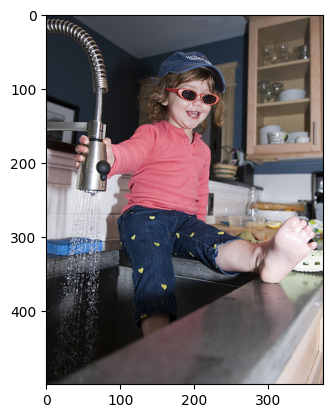

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
man in glasses and jean jacket eats


In [29]:
pic = list(encoding_test.keys())[259]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

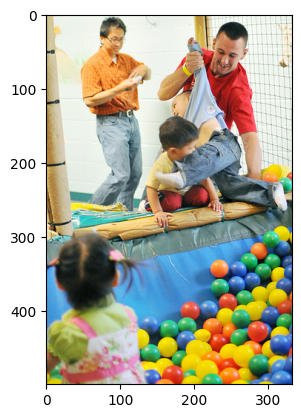

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
two children playing on plastic toys


In [34]:
pic = list(encoding_test.keys())[301]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

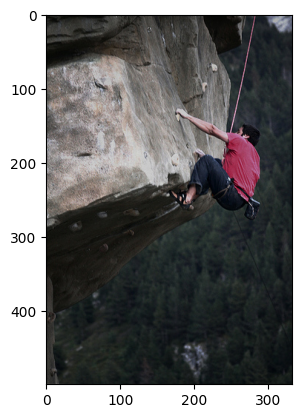

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
man rock climbs


In [17]:
pic = list(encoding_test.keys())[999]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

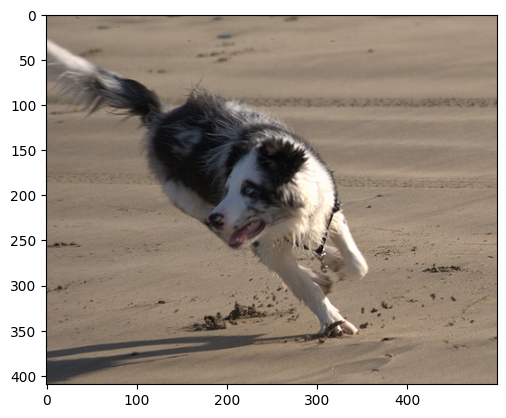

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
dog is running on the beach


In [22]:
pic = list(encoding_test.keys())[670]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

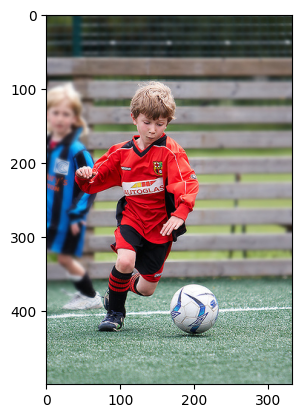

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
two soccer players attempt to hit ball


In [23]:
pic = list(encoding_test.keys())[777]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))

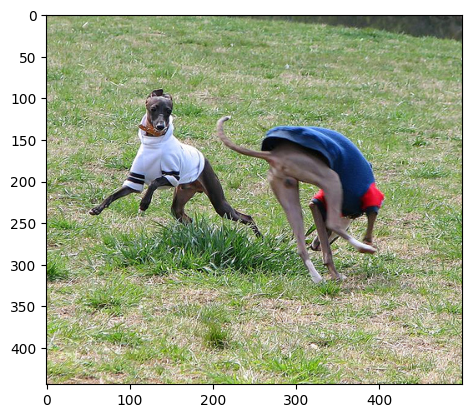

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
dog runs with his tongue out


In [20]:
pic = list(encoding_test.keys())[900]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(os.path.join(images ,pic))
plt.imshow(x)
plt.show()
print(greedy_search(img))